In [3]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
import warnings
warnings.filterwarnings('ignore')

In [4]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [5]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [7]:
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

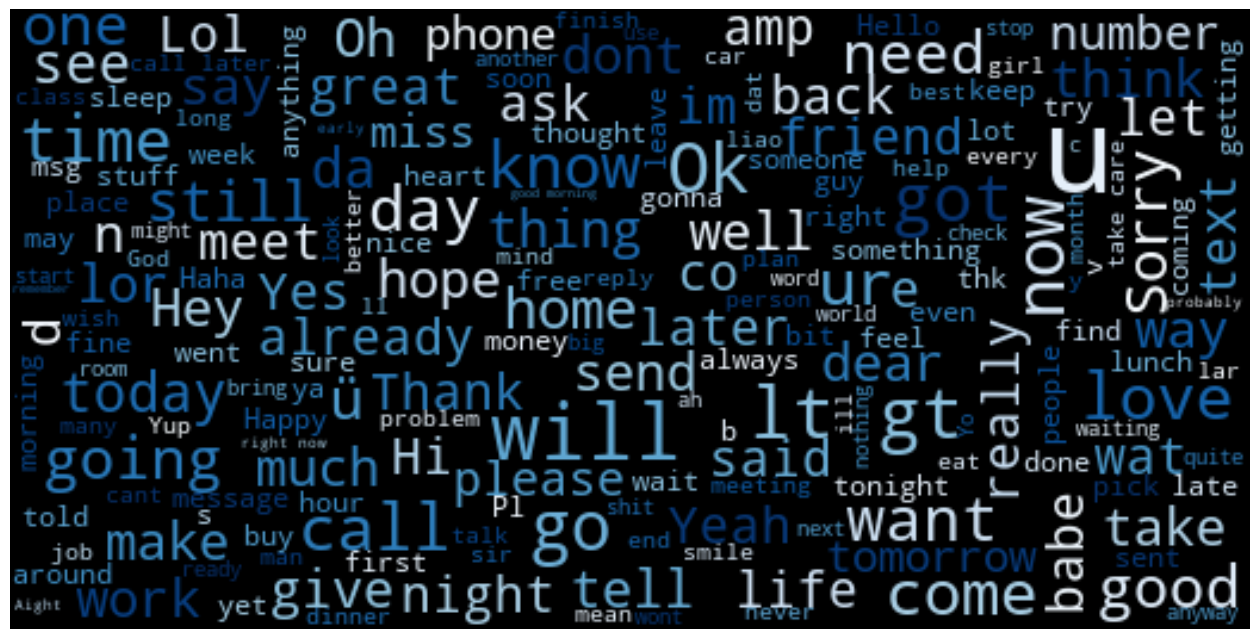

In [8]:
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

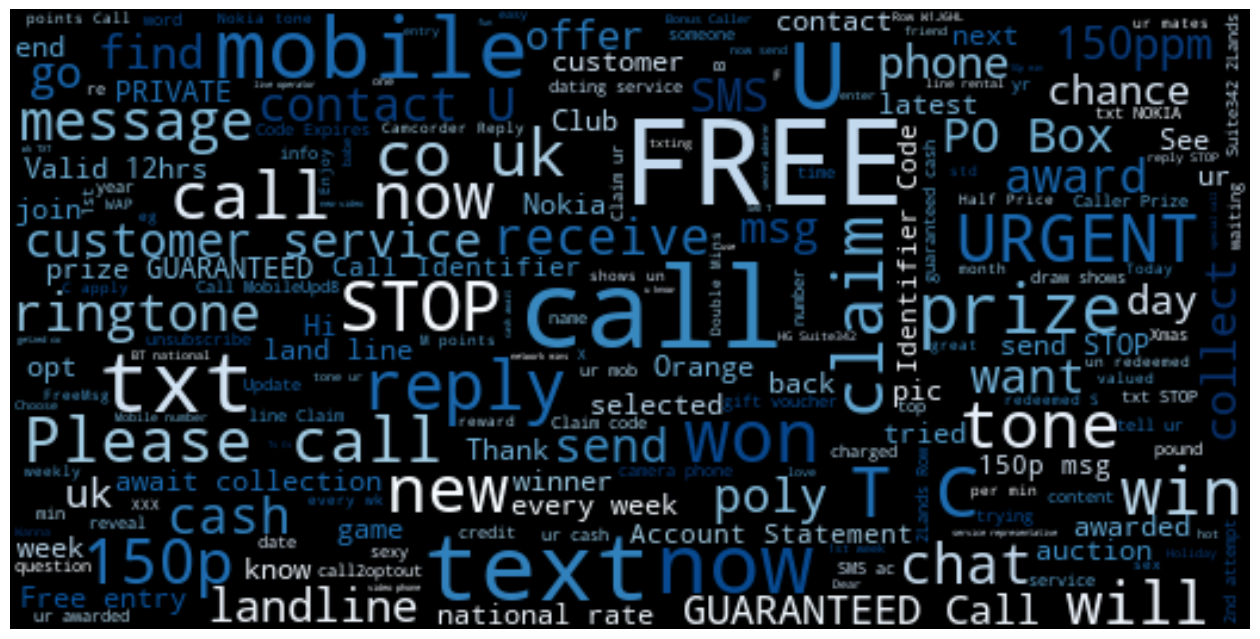

In [47]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

Text(0, 0.5, 'Count')

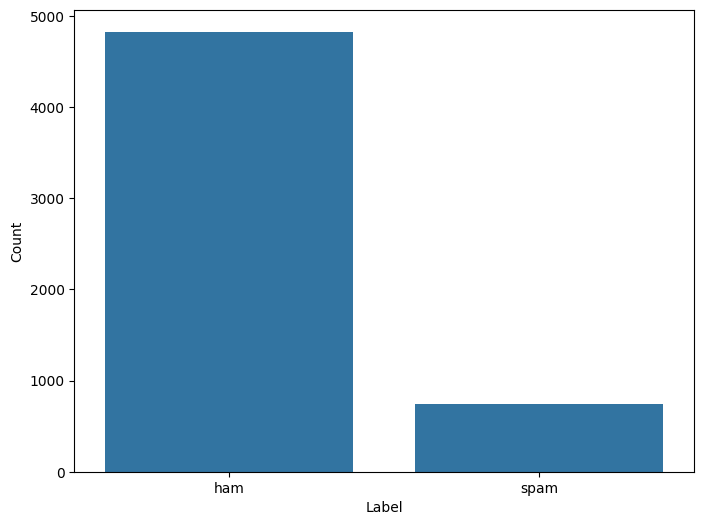

In [10]:
plt.figure(figsize=(8, 6))
sns.barplot(x=messages['label'].value_counts().index, y=messages['label'].value_counts())
plt.xlabel('Label')
plt.ylabel('Count')

In [11]:
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)


(747, 2) (747, 2)


Text(0.5, 0, 'Message types')

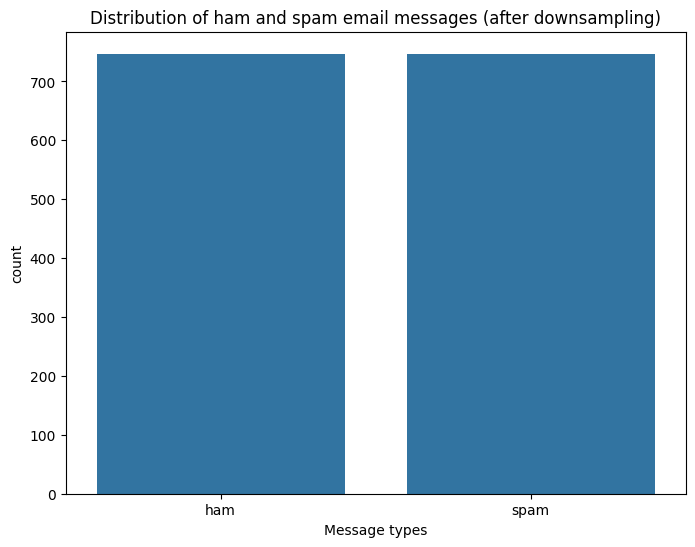

In [12]:
msg_df = pd.concat([ham_msg_df, spam_msg_df]).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(x = 'label',data = msg_df)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [13]:
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values


train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [14]:
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [15]:
word_index = tokenizer.word_index

In [16]:
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


In [17]:
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [18]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [19]:
vocab_size = 500
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [20]:
# Dense Model
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

In [25]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [26]:
history = model.fit(training_padded, train_labels, epochs=20, validation_data=(testing_padded, test_labels), verbose=2)

Epoch 1/20
38/38 - 2s - loss: 0.0830 - accuracy: 0.9715 - val_loss: 0.1166 - val_accuracy: 0.9498 - 2s/epoch - 45ms/step
Epoch 2/20
38/38 - 0s - loss: 0.0795 - accuracy: 0.9732 - val_loss: 0.1151 - val_accuracy: 0.9532 - 449ms/epoch - 12ms/step
Epoch 3/20
38/38 - 0s - loss: 0.0744 - accuracy: 0.9741 - val_loss: 0.1113 - val_accuracy: 0.9565 - 484ms/epoch - 13ms/step
Epoch 4/20
38/38 - 0s - loss: 0.0703 - accuracy: 0.9774 - val_loss: 0.1168 - val_accuracy: 0.9431 - 482ms/epoch - 13ms/step
Epoch 5/20
38/38 - 1s - loss: 0.0710 - accuracy: 0.9749 - val_loss: 0.1163 - val_accuracy: 0.9431 - 516ms/epoch - 14ms/step
Epoch 6/20
38/38 - 1s - loss: 0.0699 - accuracy: 0.9782 - val_loss: 0.1084 - val_accuracy: 0.9599 - 549ms/epoch - 14ms/step
Epoch 7/20
38/38 - 1s - loss: 0.0677 - accuracy: 0.9774 - val_loss: 0.1102 - val_accuracy: 0.9532 - 593ms/epoch - 16ms/step
Epoch 8/20
38/38 - 1s - loss: 0.0590 - accuracy: 0.9799 - val_loss: 0.1080 - val_accuracy: 0.9498 - 543ms/epoch - 14ms/step
Epoch 9/20


In [27]:
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 7ms/step - loss: 0.1193 - accuracy: 0.9532


[0.11930488795042038, 0.953177273273468]

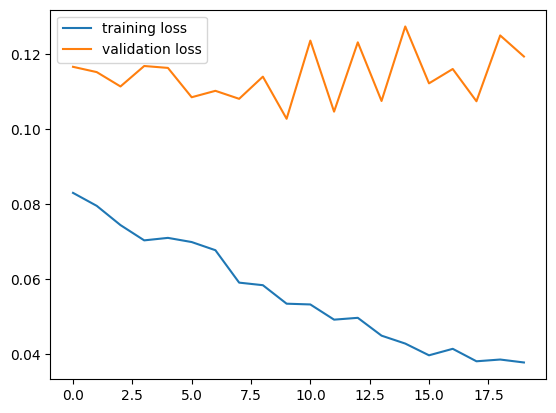

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])

In [29]:
# LSTM model
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(64, dropout=0.2, return_sequences=True))
model1.add(LSTM(64, dropout=0.2, return_sequences=True))
model1.add(LSTM(64, dropout=0.2, return_sequences=True))
model1.add(LSTM(64, dropout=0.2, return_sequences=True))
model1.add(LSTM(64, dropout=0.2, return_sequences=False))
model1.add(Dense(64,activation='relu'))
model1.add(Dense(64,activation='relu'))
model1.add(Dense(64,activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [30]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm (LSTM)                 (None, 50, 64)            20736     
                                                                 
 lstm_1 (LSTM)               (None, 50, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 50, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 50, 64)            33024     
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)               

In [38]:
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics = ['accuracy'])

In [39]:
history = model1.fit(training_padded,train_labels,validation_data=(testing_padded,test_labels),epochs= 10,callbacks=EarlyStopping(monitor='val_loss', patience=3))

Epoch 1/10
38/38 [==============================] - 22s 205ms/step - loss: 0.1210 - accuracy: 0.9732 - val_loss: 0.1208 - val_accuracy: 0.9699
Epoch 2/10
38/38 [==============================] - 3s 77ms/step - loss: 0.0803 - accuracy: 0.9816 - val_loss: 0.0953 - val_accuracy: 0.9732
Epoch 3/10
38/38 [==============================] - 4s 99ms/step - loss: 0.0525 - accuracy: 0.9874 - val_loss: 0.1342 - val_accuracy: 0.9632
Epoch 4/10
38/38 [==============================] - 4s 104ms/step - loss: 0.0458 - accuracy: 0.9900 - val_loss: 0.1059 - val_accuracy: 0.9632
Epoch 5/10
38/38 [==============================] - 4s 99ms/step - loss: 0.0435 - accuracy: 0.9883 - val_loss: 0.0778 - val_accuracy: 0.9766
Epoch 6/10
38/38 [==============================] - 4s 103ms/step - loss: 0.0519 - accuracy: 0.9883 - val_loss: 0.0633 - val_accuracy: 0.9766
Epoch 7/10
38/38 [==============================] - 4s 104ms/step - loss: 0.0375 - accuracy: 0.9916 - val_loss: 0.1576 - val_accuracy: 0.9599
Epoch 8/

In [40]:
model1.evaluate(testing_padded,test_labels)

10/10 [==============================] - 1s 47ms/step - loss: 0.0970 - accuracy: 0.9799


[0.09697101265192032, 0.9799330830574036]

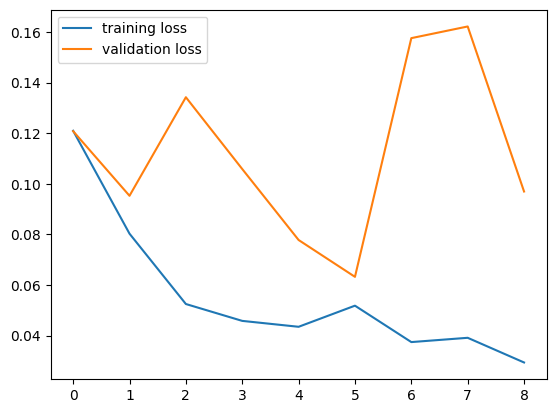

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])

In [42]:
classes = ['Ham','Spam']
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return ["Spam" if l == True else "Ham" for l in (model1.predict(padded)) > 0.5]

In [48]:
predict_spam(["""
Mr. Vijay won Rs. 1,00,00,000.

Play on RummyCircle & Win daily.
Get welcome Bonus of Rs.10000. Optout sms RCOUT to 56161.
Click: http://gmg.im/jIPbck -RUMGAME
""",
"""
Hi student,
Last 24 hours left to apply for BYJU'S Scholarship Test.
Win up to a 100% scholarship.
Apply Now http://gmg.im/eGACVg              
""",
"""
Hey, Long time no see, How are you doing?
"""])

1/1 [==============================] - 0s 222ms/step


['Spam', 'Spam', 'Ham']